In [1]:
import kagglehub
sciencelabwork_hyperspectral_image_sensing_dataset_ground_truth_path = kagglehub.dataset_download('sciencelabwork/hyperspectral-image-sensing-dataset-ground-truth')
print('Data source import complete.')

Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_corrected.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC_gt.mat


In [3]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [4]:
!pip install ripser persim

In [5]:
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import scipy.ndimage as nd
import numpy as np
from ripser import ripser
from scipy.stats import entropy
from tensorflow.keras import layers


In [6]:
# Load Indian Pines HSI cube and labels
data = sio.loadmat("/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat")
cube = data['indian_pines_corrected']  # Shape: (145, 145, 200)

gt_data = sio.loadmat("/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat")
gt = gt_data['indian_pines_gt']        # Shape: (145, 145)

# Normalize spectral bands per-pixel
H, W, B = cube.shape
cube_2d = cube.reshape(-1, B)
scaler = StandardScaler()
cube_norm = scaler.fit_transform(cube_2d)
cube_norm = cube_norm.reshape(H, W, B)

print("Normalized cube shape:", cube_norm.shape) #Normalized cube shape: (145, 145, 200)
print("Label shape:", gt.shape) #Label shape: (145, 145)

Normalized cube shape: (145, 145, 200)
Label shape: (145, 145)


In [7]:
#Patch Extraction for Training
def extract_patches_tf(cube, labels, patch_size=13):
    pad = patch_size // 2
    H, W, B = cube.shape

    padded_cube = np.pad(cube, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    X_patches = []
    y_labels = []

    for i in range(H):
        for j in range(W):
            if labels[i, j] == 0:
                continue
            patch = padded_cube[i:i+patch_size, j:j+patch_size, :]
            X_patches.append(patch)
            y_labels.append(labels[i, j] - 1)  # classes from 0

    return np.array(X_patches), np.array(y_labels)

# Extract labeled patches
X, y = extract_patches_tf(cube_norm, gt, patch_size=13)
num_classes = np.max(y) + 1
print("X shape:", X.shape)  # (N, 13, 13, B) X shape: (10249, 13, 13, 200)
print("y shape:", y.shape)  # (N,) y shape: (10249,)
print("Num classes:", num_classes) #Num classes: 16

X shape: (10249, 13, 13, 200)
y shape: (10249,)
Num classes: 16


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Convert labels to one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Train:", X_train.shape) #Train: (6149, 13, 13, 200)
print("Val:", X_val.shape) #Val: (2050, 13, 13, 200)
print("Test:", X_test.shape) #Test: (2050, 13, 13, 200)

Train: (6149, 13, 13, 200)
Val: (2050, 13, 13, 200)
Test: (2050, 13, 13, 200)


# Morphological Band Saliency Attention

In [9]:
# Morphological operation: returns 4-band saliency scores
def morph_saliency_ops(patch):
    # patch: shape (13, 13, 200) — numpy array
    saliency = []
    for i in range(patch.shape[-1]):
        band = patch[:, :, i]
        d = nd.grey_dilation(band, size=(3, 3))
        e = nd.grey_erosion(band, size=(3, 3))
        o = nd.grey_opening(band, size=(3, 3))
        c = nd.grey_closing(band, size=(3, 3))

        score = (
            np.mean((d - band) ** 2) +
            np.mean((e - band) ** 2) +
            np.mean((o - band) ** 2) +
            np.mean((c - band) ** 2)
        )
        saliency.append(score)
    return np.array(saliency, dtype=np.float32)  # shape: (200,)

## Vectorize Band Ranking + Select Top-K Bands

In [10]:
def select_topk_bands(X_full, k=30, sample_size=1000):
    print("Sampling for MBSA...")
    if X_full.shape[0] > sample_size:
        idx = np.random.choice(X_full.shape[0], sample_size, replace=False)
        X_sample = X_full[idx]
    else:
        X_sample = X_full

    band_saliency = np.zeros(X_sample.shape[-1])
    for i in range(X_sample.shape[0]):
        s = morph_saliency_ops(X_sample[i])
        band_saliency += s
    band_saliency /= X_sample.shape[0]

    topk_indices = np.argsort(band_saliency)[-k:]
    print("Top-k bands:", topk_indices)
    return topk_indices

In [11]:
top_k = 30
topk_indices = select_topk_bands(X_train, k=top_k, sample_size=1000)

Sampling for MBSA...
Top-k bands: [ 91  35  81  94  79  74   2  92  60 198  75  83 143 144  96  82  95   1
  85  84  93 102  86  88  89  90 103  87 199   0]


In [12]:
X_train_sel = X_train[..., topk_indices]
X_val_sel   = X_val[..., topk_indices]
X_test_sel  = X_test[..., topk_indices]

# Topological Feature Extraction (with ripser)

In [13]:
def compute_persistence_entropy(diagram, epsilon=1e-8):
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[lifetimes > 0]

    if len(lifetimes) == 0 or np.sum(lifetimes) < epsilon:
        return 0.0

    probs = lifetimes / (np.sum(lifetimes) + epsilon)
    return entropy(probs)

# Extract Topological Feature from One Spectrum

In [14]:
def extract_topo_feature(spectrum_1d):
    """
    spectrum_1d: (30,) vector → reshaped to (30, 1)
    Returns: scalar entropy value
    """
    point_cloud = spectrum_1d.reshape(-1, 1)
    dgms = ripser(point_cloud, maxdim=0)['dgms'][0]  # 0D homology
    pe = compute_persistence_entropy(dgms)
    return pe

In [15]:
def generate_topo_features(X_patches):
    topo = []
    for i in range(len(X_patches)):
        spectrum = np.mean(X_patches[i], axis=(0, 1))  # (30,)
        topo_feat = extract_topo_feature(spectrum)
        topo.append(topo_feat)
    return np.array(topo).reshape(-1, 1)

topo_train = generate_topo_features(X_train_sel)
topo_val   = generate_topo_features(X_val_sel)
topo_test  = generate_topo_features(X_test_sel)

print("Topological feature shapes:", topo_train.shape, topo_val.shape, topo_test.shape)

Topological feature shapes: (6149, 1) (2050, 1) (2050, 1)


X_train_sel: (6149, 13, 13, 30) → input to CNN

topo_train: (6149, 1) → topological entropy vector

y_train_cat: (6149, 16) → one-hot labels

#  RGConv Block (Spatial Extractor)

In [16]:
from tensorflow.keras import layers, models
def RGConvBlock(input_tensor, filters):
    x1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    x2 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    gated = layers.Multiply()([x1, x2])

    # Enhanced feature propagation
    x3 = layers.Conv2D(filters, 3, padding='same', activation='relu')(gated)
    x4 = layers.Conv2D(filters, 3, padding='same', activation='relu')(gated)
    output = layers.Multiply()([x3, x4])
    return output

# UNet++ Decoder Block (Spectral Decoder)

In [17]:
from tensorflow.keras import layers

def UNetPlusPlusDecoder(input_tensor, filters=64):
    # Initial Conv block
    conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(conv1)

    # Downsample
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bottleneck
    conv2 = layers.Conv2D(filters * 2, 3, padding='same', activation='relu')(pool1)
    conv2 = layers.Conv2D(filters * 2, 3, padding='same', activation='relu')(conv2)

    # Up + concat + conv
    up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv2)
    up1 = layers.Resizing(conv1.shape[1], conv1.shape[2])(up1)  # Ensure exact size match
    merge = layers.Concatenate()([up1, conv1])

    conv3 = layers.Conv2D(filters, 3, padding='same', activation='relu')(merge)
    conv3 = layers.Conv2D(filters, 3, padding='same', activation='relu')(conv3)

    # Gated refinement
    gate_1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    gate_2 = layers.Conv2D(filters, 3, padding='same', activation='sigmoid')(input_tensor)
    gated = layers.Multiply()([gate_1, gate_2])  # Feature-wise attention
    # Add spectral residual
    output = layers.Add()([conv3, gated])
    return output

In [18]:
def TopoAttentionFusion(spectral_feat, topo_feat, filters=64):
    """
    Fuse spectral feature maps with topological descriptors using learned attention.
    Args:
        spectral_feat: [B, H, W, C]
        topo_feat:     [B, 1] or [B, D]
        filters:       int, number of output filters (must match spectral_feat channels)
    Returns:
        Fused feature map: [B, H, W, C]
    """
    # Project topo_feat to match spectral channels
    topo_dense = layers.Dense(filters, activation='relu')(topo_feat)  # [B, filters]
    topo_reshape = layers.Reshape((1, 1, filters))(topo_dense)         # [B, 1, 1, C]

    # Learnable scaling of spectral features
    scaled_spectral = layers.Multiply()([spectral_feat, topo_reshape])  # Element-wise scale

    # Optional recalibration via Conv2D (acts like SE block)
    recal = layers.Conv2D(filters, kernel_size=1, padding='same', activation='relu')(scaled_spectral)

    return recal

#### Topological Attention Fusion Layer

## Final Model Assembly: TopoMorph-RGNet v2

In [19]:
def build_topomorph_model(input_shape, topo_dim, num_classes):
    # Inputs
    input_img = layers.Input(shape=input_shape)      # (13,13,30)
    input_topo = layers.Input(shape=(topo_dim,))     # (1)

    # Spatial stream
    x_spatial = RGConvBlock(input_img, filters=64)

    # Spectral decoder
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    # Topological attention fusion
    x_fused = TopoAttentionFusion(x_spectral, input_topo, filters=64)

    # Combine spatial & spectral-topo
    combined = layers.Add()([x_spatial, x_spectral])
    pooled = layers.GlobalAveragePooling2D()(combined)

    # Final classifier
    output = layers.Dense(num_classes, activation='softmax')(pooled)

    # Model
    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model

In [20]:
model = build_topomorph_model(input_shape=(13,13,30), topo_dim=1, num_classes=16)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

Inputs:

HSI patch → (13, 13, 30)

Topological entropy → (1,)

Two streams:

RGConv spatial path

UNet++ spectral decoder + topological fusion

Final classifier → 16 classes

#### Input 1 → HSI Patch → RGConv + UNet++

#### Input 2 → Topological Entropy → Attention gating

#### Fused spatial & spectral streams → final dense classifier

In [21]:
print(type(X_train_sel), X_train_sel.shape)
print(type(topo_train), topo_train.shape)
print(type(y_train_cat), y_train_cat.shape)
'''<class 'numpy.ndarray'> (6149, 13, 13, 30)
<class 'numpy.ndarray'> (6149, 1)
<class 'numpy.ndarray'> (6149, 16)'''

<class 'numpy.ndarray'> (6149, 13, 13, 30)
<class 'numpy.ndarray'> (6149, 1)
<class 'numpy.ndarray'> (6149, 16)


"<class 'numpy.ndarray'> (6149, 13, 13, 30)\n<class 'numpy.ndarray'> (6149, 1)\n<class 'numpy.ndarray'> (6149, 16)"

In [22]:
# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat))
train_dataset = train_dataset.shuffle(buffer_size=2048).batch(64)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat))
val_dataset = val_dataset.batch(64)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat))
test_dataset = test_dataset.batch(64)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
    ModelCheckpoint("best_topomorph.keras", monitor='val_accuracy', save_best_only=True)
]

In [24]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.5970 - loss: 1.2955 - val_accuracy: 0.8556 - val_loss: 0.4257
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8795 - loss: 0.3732 - val_accuracy: 0.9356 - val_loss: 0.2046
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9477 - loss: 0.1542 - val_accuracy: 0.9434 - val_loss: 0.2158
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9599 - loss: 0.1381 - val_accuracy: 0.9590 - val_loss: 0.1784
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9638 - loss: 0.1446 - val_accuracy: 0.9673 - val_loss: 0.0906
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9724 - loss: 0.0766 - val_accuracy: 0.9805 - val_loss: 0.0765
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9796 - loss: 0.0802 - val_accuracy: 0.9863 - val_loss: 0.0465
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9892 - loss: 0.0333 - val_accuracy: 0.9922 - 

In [25]:
model.save("best_topomorph.keras")

In [26]:
from tensorflow.keras.models import load_model
proposed_model = load_model("best_topomorph.keras")

In [27]:
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])
y_true = np.argmax(y_test_cat, axis=1)

# Predict probabilities
y_pred_probs = proposed_model.predict(test_dataset)
y_pred_proposed = np.argmax(y_pred_probs, axis=1)
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, f1_score

oa = accuracy_score(y_true, y_pred_proposed)
kappa = cohen_kappa_score(y_true, y_pred_proposed)
f1 = f1_score(y_true, y_pred_proposed, average='macro')
conf_mat = confusion_matrix(y_true, y_pred_proposed)

# AA (Average Accuracy per class)
report = classification_report(y_true, y_pred_proposed, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16)
             if str(i) in report])  # Ignore background class 0

print("Overall Accuracy (OA):", oa)
print("Average Accuracy (AA):", aa)
print("Kappa Coefficient:", kappa)
print("F1 Score (Macro):", f1)
print("Confusion Matrix:\n", conf_mat)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0030
Test Loss: 0.002064727246761322
Test Accuracy: 0.9995121955871582
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Overall Accuracy (OA): 0.9995121951219512
Average Accuracy (AA): 0.9994350282485875
Kappa Coefficient: 0.9994439352458525
F1 Score (Macro): 0.9981314784506274
Confusion Matrix:
 [[  9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 285   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  48   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  97   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 146   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   6   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  95   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 19

## A1

###  PCA variant:

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(X_data, num_components=30):
    N, H, W, B = X_data.shape
    X_flat = X_data.reshape(-1, B)
    pca = PCA(n_components=num_components)
    X_pca = pca.fit_transform(X_flat)
    X_pca_reshaped = X_pca.reshape(N, H, W, num_components)
    return X_pca_reshaped

X_train_pca = apply_pca(X_train)
X_val_pca = apply_pca(X_val)
X_test_pca = apply_pca(X_test)

### All Bands (no band selection):

In [ ]:
X_train_sel = X_train
X_val_sel = X_val
X_test_sel = X_test

🔁 Now run the training and evaluation loop 3 times, one for each variant. Below is the full code block you can use — only change X_train_sel, X_val_sel, X_test_sel each time.

| Run           | Code Before                                |
| ------------- | ------------------------------------------ |
| **MBSA**      | `X_train_sel = X_train[..., topk_indices]` |
| **PCA**       | `X_train_sel = X_train_pca`                |
| **All Bands** | `X_train_sel = X_train`                    |


In [ ]:
# Topological features (reuse if not recalculating)
topo_train = generate_topo_features(X_train_sel)
topo_val = generate_topo_features(X_val_sel)
topo_test = generate_topo_features(X_test_sel)

# Model
model = build_topomorph_model(input_shape=X_train_sel.shape[1:], topo_dim=1, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a1_variant_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)

# Evaluate
model = load_model("a1_variant_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, Macro F1: {f1:.4f}")

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.5147 - loss: 2.0190 - val_accuracy: 0.7551 - val_loss: 0.7243
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8455 - loss: 0.4565 - val_accuracy: 0.8385 - val_loss: 0.4304
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8606 - loss: 0.5461 - val_accuracy: 0.9137 - val_loss: 0.2416
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9383 - loss: 0.1896 - val_accuracy: 0.9293 - val_loss: 0.2149
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9550 - loss: 0.1336 - val_accuracy: 0.9707 - val_loss: 0.0880
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9630 - loss: 0.1188 - val_accuracy: 0.9751 - val_loss: 0.0884
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9638 - loss: 0.1323 - val_accuracy: 0.9639 - val_loss: 0.1016
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9712 - loss: 0.0841 - val_accuracy: 0

## All bands
Test Loss: 0.005679208319634199

Test Accuracy: 0.9985365867614746

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
OA: 0.9985,

AA: 0.9966,

Kappa: 0.9983,

Macro F1: 0.9980

In [ ]:
# 1. Assign PCA data to _sel variables
X_train_sel = X_train_pca
X_val_sel = X_val_pca
X_test_sel = X_test_pca

# 2. Generate topological features from PCA-selected bands
topo_train = generate_topo_features(X_train_sel)
topo_val   = generate_topo_features(X_val_sel)
topo_test  = generate_topo_features(X_test_sel)

# 3. Build and compile model
model = build_topomorph_model(input_shape=X_train_sel.shape[1:], topo_dim=1, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Create datasets using _sel variables
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a1_variant_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)

# Evaluate
model = load_model("a1_variant_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, Macro F1: {f1:.4f}")


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6200 - loss: 1.6878 - val_accuracy: 0.9146 - val_loss: 0.2697
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9535 - loss: 0.1484 - val_accuracy: 0.9395 - val_loss: 0.2138
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9793 - loss: 0.0622 - val_accuracy: 0.9327 - val_loss: 0.2319
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9898 - loss: 0.0401 - val_accuracy: 0.9454 - val_loss: 0.2047
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.9439 - val_loss: 0.2317
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9717 - loss: 0.0946 - val_accuracy: 0.9717 - val_loss: 0.1035
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9866 - loss: 0.0582 - val_accuracy: 0.9483 - val_loss: 0.2082
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0168 - val_accuracy: 0

#### pca

Test Loss: 0.029735520482063293

Test Accuracy: 0.9878048896789551

OA: 0.9878,

AA: 0.9724,

Kappa: 0.9861,

Macro F1: 0.9822

In [ ]:
X_train_sel = X_train[..., topk_indices]
X_val_sel   = X_val[..., topk_indices]
X_test_sel  = X_test[..., topk_indices]

In [ ]:
# Topological features for mbsa
topo_train = generate_topo_features(X_train_sel)
topo_val = generate_topo_features(X_val_sel)
topo_test = generate_topo_features(X_test_sel)

# Model
model = build_topomorph_model(input_shape=X_train_sel.shape[1:], topo_dim=1, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a1_variant_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)

# Evaluate
model = load_model("a1_variant_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, Macro F1: {f1:.4f}")

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5533 - loss: 1.3814 - val_accuracy: 0.8922 - val_loss: 0.3336
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9127 - loss: 0.2595 - val_accuracy: 0.9624 - val_loss: 0.1321
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9527 - loss: 0.1529 - val_accuracy: 0.9829 - val_loss: 0.0675
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9756 - loss: 0.0681 - val_accuracy: 0.9776 - val_loss: 0.0702
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9680 - loss: 0.0926 - val_accuracy: 0.9439 - val_loss: 0.4198
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9610 - loss: 0.1846 - val_accuracy: 0.9785 - val_loss: 0.0691
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9856 - loss: 0.0377 - val_accuracy: 0.9902 - val_loss: 0.0299
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9904 - loss: 0.0325 - val_accuracy: 0

#### mbsa
Test Loss: 0.003621302777901292

Test Accuracy: 0.9995121955871582

OA: 0.9995,

AA: 0.9965,

Kappa: 0.9994,

Macro F1: 0.9980

## ✅ A2: Persistent Homology Gate On vs Off

### To disable topo gate:

In [ ]:
def build_topomorph_model_no_topo(input_shape, num_classes):
    input_img = layers.Input(shape=input_shape)
    x_spatial = RGConvBlock(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)
    combined = layers.Add()([x_spatial, x_spectral])
    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)
    model = models.Model(inputs=input_img, outputs=output)
    return model


In [ ]:
# If using MBSA
X_train_sel = X_train[..., topk_indices]
X_val_sel   = X_val[..., topk_indices]
X_test_sel  = X_test[..., topk_indices]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sel, y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val_sel, y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test_sel, y_test_cat)).batch(64)


### Build and train the "no-topo" model:

In [ ]:
model = build_topomorph_model_no_topo(input_shape=X_train_sel.shape[1:], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a2_no_topo_model.keras", monitor='val_accuracy', save_best_only=True)
]
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.5888 - loss: 1.2917 - val_accuracy: 0.8444 - val_loss: 0.4396
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9120 - loss: 0.2867 - val_accuracy: 0.9541 - val_loss: 0.1367
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9568 - loss: 0.1347 - val_accuracy: 0.8849 - val_loss: 0.3350
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9554 - loss: 0.1327 - val_accuracy: 0.9585 - val_loss: 0.1148
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9686 - loss: 0.0838 - val_accuracy: 0.9756 - val_loss: 0.0997
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9780 - loss: 0.0850 - val_accuracy: 0.9917 - val_loss: 0.0370
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9912 - loss: 0.0233 - val_accuracy: 0.9873 - val_loss: 0.0373
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9918 - loss: 0.0285 - val_accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score

model = load_model("a2_no_topo_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"A2 (No Topo) → OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, F1: {f1:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9994 - loss: 0.0051
Test Loss: 0.004483590833842754
Test Accuracy: 0.9990243911743164
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
A2 (No Topo) → OA: 0.9990, AA: 0.9930, Kappa: 0.9989, F1: 0.9960


accuracy: 0.9994 - loss: 0.0051

Test Loss: 0.004483590833842754

Test Accuracy: 0.9990243911743164

A2 (No Topo) → OA: 0.9990,

AA: 0.9930,

Kappa: 0.9989,

F1: 0.9960

Cross-Gating (current) – implemented via TopoAttentionFusion(...)



## ✅ A3: Fusion Method – Cross-Gating vs Late Fusion vs Additive

### Late Fusion (no interaction, average outputs):

In [ ]:
def build_latefusion_model(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)
    input_topo = layers.Input(shape=(topo_dim,))
    x_spatial = RGConvBlock(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    pooled_img = layers.GlobalAveragePooling2D()(x_spatial)
    pooled_spec = layers.GlobalAveragePooling2D()(x_spectral)
    topo_dense = layers.Dense(64, activation='relu')(input_topo)

    combined = layers.Average()([pooled_img, pooled_spec, topo_dense])
    output = layers.Dense(num_classes, activation='softmax')(combined)
    return models.Model(inputs=[input_img, input_topo], outputs=output)


In [ ]:
model = build_latefusion_model(input_shape=X_train_sel.shape[1:], topo_dim=topo_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a3_latefusion_model.keras", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)
model = load_model("a3_latefusion_model.keras")
res = model.evaluate(test_dataset)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.0095 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0107 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0102 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0083 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0092 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0089 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0117 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, jaccard_score

# Step 1: Get predictions and true labels
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_dataset], axis=0)

# Step 2: Compute OA (Overall Accuracy)
oa = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy (OA): {oa:.4f}")

# Step 3: Compute AA (Average Accuracy)
conf_mat = confusion_matrix(y_true, y_pred)
class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
aa = np.mean(class_acc)
print(f"Average Accuracy (AA): {aa:.4f}")

# Step 4: Compute Precision, Recall, F1 (Macro avg)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Step 5: Compute mIoU (mean Intersection over Union)
miou = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
print(f"Mean IoU (mIoU):   {miou:.4f}")

# Step 6: Full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Overall Accuracy (OA): 0.0044
Average Accuracy (AA): 0.0625
Precision (macro): 0.0003
Recall (macro):    0.0625
F1-score (macro):  0.0005
Mean IoU (mIoU):   0.0003

Classification Report:
              precision    recall  f1-score   support

           0     0.0044    1.0000    0.0087         9
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       166
           3     0.0000    0.0000    0.0000        48
           4     0.0000    0.0000    0.0000        97
           5     0.0000    0.0000    0.0000       146
           6     0.0000    0.0000    0.0000         6
           7     0.0000    0.0000    0.0000        95
           8     0.0000    0.0000    0.0000         4
           9     0.0000    0.0000    0.0000       195
          10     0.0000    0.0000    0.0000       491
          11     0.0000    0.0000    0.0000       118
          12     0.0000    0.0000    0.0000        41
          13   

### ✅ 2. Cross-Gating Fusion (your existing TopoMorph RGNet)


In [ ]:
def build_topomorph_model_crossgate(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)      # e.g., (13, 13, 30)
    input_topo = layers.Input(shape=(topo_dim,))     # e.g., (1,)

    # Branch 1: Spatial features via RGConv
    x_spatial = RGConvBlock(input_img, filters=64)

    # Branch 2: Spectral features via UNet++
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    # Apply Cross-Gating Fusion (TopoAttention) on Spectral + Topo
    x_fused = TopoAttentionFusion(x_spectral, input_topo, filters=64)

    # Combine fused spectral + spatial features
    combined = layers.Add()([x_spatial, x_fused])  # ✅ use fused spectral!

    # Final layers
    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)

    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model

In [ ]:
model = build_topomorph_model_crossgate(input_shape=X_train_sel.shape[1:], topo_dim=topo_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_crossgate.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, accuracy_score, jaccard_score
import numpy as np

# Predict
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
aa = np.mean(conf_matrix.diagonal() / conf_matrix.sum(axis=1))
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average=None)
miou = jaccard_score(y_true, y_pred, average='macro')

# Dict of results
results_crossgate = {
    "OA": oa,
    "AA": aa,
    "Kappa": kappa,
    "F1_per_class": f1,
    "mIoU": miou
}

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0104 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0094 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0098 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0121 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0096 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0100 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0092 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [ ]:
results_crossgate

{'OA': 0.004390243902439025,
 'AA': 0.0625,
 'Kappa': 0.0,
 'F1_per_class': array([0.00874211, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'mIoU': 0.00027439024390243905}

### Additive Fusion (your original fusion):

In [ ]:
def build_addfusion_model(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)
    input_topo = layers.Input(shape=(topo_dim,))

    x_spatial = RGConvBlock(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    pooled_img = layers.GlobalAveragePooling2D()(x_spatial)
    pooled_spec = layers.GlobalAveragePooling2D()(x_spectral)
    topo_dense = layers.Dense(64, activation='relu')(input_topo)

    # Simple element-wise add
    added = layers.Add()([pooled_img, pooled_spec, topo_dense])
    output = layers.Dense(num_classes, activation='softmax')(added)

    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model


In [ ]:
model = build_addfusion_model(X_train_sel.shape[1:], topo_train.shape[1], num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a3_addfusion_model.keras", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)
model = load_model("a3_addfusion_model.keras")
res = model.evaluate(test_dataset)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0111 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0101 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0087 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0090 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0103 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import numpy as np

# Predict on test data
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)
print("Overall Accuracy (OA)%:", oa*100)

# Average Accuracy (AA)
conf_mat = confusion_matrix(y_true, y_pred)
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
aa = np.mean(class_accuracies)
print("Average Accuracy (AA)%:", aa*100)

# F1-Score (per class & average)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_per_class = f1_score(y_true, y_pred, average=None)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Per Class):", f1_per_class)

# Precision & Recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)

# mIoU (mean Intersection over Union)
miou = jaccard_score(y_true, y_pred, average='macro')
print("Mean IoU (mIoU):", miou)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Overall Accuracy (OA)%: 0.4390243902439025
Average Accuracy (AA)%: 6.25
F1 Score (Macro): 0.0005463817387081108
F1 Score (Per Class): [0.00874211 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Precision (Macro): 0.00027439024390243905
Recall (Macro): 0.0625
Mean IoU (mIoU): 0.00027439024390243905

Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.01         9
           1       0.00      0.00      0.00       285
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00       146
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        95
           8       0.00      0.00      0.00   

## ✅ A4: RGC Depth and Kernel Size

In [ ]:
# Variant: deeper RGConvBlock with larger kernels
def RGConvBlock_deep(input_tensor, filters):
    x = input_tensor
    for _ in range(4):  # more layers
        x1 = layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
        x2 = layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
        x = layers.Multiply()([x1, x2])
    return x

In [ ]:
def build_topomorph_model_deepRG(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)       # e.g., (13,13,30)
    input_topo = layers.Input(shape=(topo_dim,))      # e.g., (1,)

    x_spatial = RGConvBlock_deep(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    x_fused = TopoAttentionFusion(x_spectral, input_topo, filters=64)
    combined = layers.Add()([x_spatial, x_fused])

    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)

    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model


In [ ]:
model = build_topomorph_model_deepRG(input_shape=X_train_sel.shape[1:], topo_dim=topo_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_deepRG.h5", monitor='val_accuracy', save_best_only=True)
]
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.0102 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0098 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0089 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0085 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0108 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0118 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

results_deepRG = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(confusion_matrix(y_true, y_pred).diagonal() / confusion_matrix(y_true, y_pred).sum(axis=1)),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "mIoU": jaccard_score(y_true, y_pred, average='macro')
}
results_deepRG

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


{'OA': 0.004390243902439025,
 'AA': 0.0625,
 'Kappa': 0.0,
 'F1_per_class': array([0.00874211, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'mIoU': 0.00027439024390243905}

## ✅ A5: Multi-Scale Input Patches

In [ ]:
def extract_multi_scale_patches_fast(cube, labels, patch_sizes=[5, 9, 13]):
    from tqdm import tqdm  # optional for progress bar

    H, W, B = cube.shape
    positions = [(i, j) for i in range(H) for j in range(W) if labels[i, j] > 0]
    y_labels = np.array([labels[i, j] - 1 for (i, j) in positions])

    X_patches = {}

    for size in patch_sizes:
        print(f"Extracting patches of size {size}×{size}...")
        pad = size // 2
        padded = np.pad(cube, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
        patches = np.zeros((len(positions), size, size, B), dtype=np.float32)

        for idx, (i, j) in enumerate(tqdm(positions)):
            patch = padded[i:i+size, j:j+size, :]
            patches[idx] = patch

        X_patches[size] = patches

    return X_patches, y_labels

In [ ]:
patch_sizes = [5, 9, 13]  # Small, medium, large scales
X_ms, y_ms = extract_multi_scale_patches_fast(cube_norm, gt, patch_sizes=patch_sizes)

Extracting patches of size 5×5...


100%|██████████| 10249/10249 [00:00<00:00, 51730.68it/s]


Extracting patches of size 9×9...


100%|██████████| 10249/10249 [00:00<00:00, 20470.63it/s]


Extracting patches of size 13×13...


100%|██████████| 10249/10249 [00:01<00:00, 7293.25it/s]


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
import numpy as np

def train_single_patch_model(X, y, num_classes=16, patch_size=5, epochs=10):
    print(f"\n▶️ Training on patch size {patch_size}...")

    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # One-hot
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    # Model (very light)
    model = Sequential([
        InputLayer(input_shape=X_train.shape[1:]),
        Conv2D(16, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train (quick)
    model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
              epochs=10, batch_size=64, verbose=2)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"✅ Test Accuracy on {patch_size}x{patch_size}: {test_acc*100:.2f}%")


In [ ]:
# Patch size 5
train_single_patch_model(X_ms[5], y_ms, patch_size=5)


▶️ Training on patch size 5...
Epoch 1/10
97/97 - 10s - 102ms/step - accuracy: 0.5163 - loss: 1.3606 - val_accuracy: 0.6351 - val_loss: 1.0502
Epoch 2/10
97/97 - 5s - 53ms/step - accuracy: 0.7099 - loss: 0.7797 - val_accuracy: 0.7400 - val_loss: 0.7281
Epoch 3/10
97/97 - 1s - 7ms/step - accuracy: 0.8099 - loss: 0.5342 - val_accuracy: 0.8044 - val_loss: 0.5289
Epoch 4/10
97/97 - 1s - 7ms/step - accuracy: 0.8603 - loss: 0.3840 - val_accuracy: 0.8234 - val_loss: 0.4585
Epoch 5/10
97/97 - 1s - 6ms/step - accuracy: 0.8980 - loss: 0.2848 - val_accuracy: 0.8722 - val_loss: 0.3386
Epoch 6/10
97/97 - 1s - 6ms/step - accuracy: 0.9291 - loss: 0.2068 - val_accuracy: 0.8420 - val_loss: 0.4393
Epoch 7/10
97/97 - 0s - 5ms/step - accuracy: 0.9413 - loss: 0.1813 - val_accuracy: 0.9361 - val_loss: 0.1908
Epoch 8/10
97/97 - 1s - 6ms/step - accuracy: 0.9673 - loss: 0.1084 - val_accuracy: 0.9483 - val_loss: 0.1596
Epoch 9/10
97/97 - 1s - 7ms/step - accuracy: 0.9722 - loss: 0.0960 - val_accuracy: 0.9463 - 

### ✅ Test Accuracy on 5x5: 93.76%

In [ ]:
# Patch size 9
train_single_patch_model(X_ms[9], y_ms, patch_size=9)


▶️ Training on patch size 9...
Epoch 1/10
97/97 - 7s - 76ms/step - accuracy: 0.6219 - loss: 1.0978 - val_accuracy: 0.7517 - val_loss: 0.6588
Epoch 2/10
97/97 - 6s - 60ms/step - accuracy: 0.8374 - loss: 0.4529 - val_accuracy: 0.8561 - val_loss: 0.4226
Epoch 3/10
97/97 - 1s - 8ms/step - accuracy: 0.9249 - loss: 0.2316 - val_accuracy: 0.9346 - val_loss: 0.1973
Epoch 4/10
97/97 - 1s - 6ms/step - accuracy: 0.9587 - loss: 0.1308 - val_accuracy: 0.9522 - val_loss: 0.1437
Epoch 5/10
97/97 - 1s - 6ms/step - accuracy: 0.9693 - loss: 0.0922 - val_accuracy: 0.9468 - val_loss: 0.1632
Epoch 6/10
97/97 - 1s - 6ms/step - accuracy: 0.9556 - loss: 0.1628 - val_accuracy: 0.9810 - val_loss: 0.0757
Epoch 7/10
97/97 - 1s - 6ms/step - accuracy: 0.9797 - loss: 0.0636 - val_accuracy: 0.9717 - val_loss: 0.0866
Epoch 8/10
97/97 - 1s - 6ms/step - accuracy: 0.9904 - loss: 0.0339 - val_accuracy: 0.9810 - val_loss: 0.0661
Epoch 9/10
97/97 - 1s - 6ms/step - accuracy: 0.9948 - loss: 0.0203 - val_accuracy: 0.9810 - va

### ✅ Test Accuracy on 9x9: 99.37%

## ✅ A6: Data-level – Noisy Bands, Partial Labels

### 🔁 Add noise to spectral bands:

In [ ]:
def add_spectral_noise(X, noise_level=0.05):
    noise = np.random.normal(0, noise_level, size=X.shape)
    return np.clip(X + noise, 0, 1)

X_train_noisy = add_spectral_noise(X_train_sel)
X_val_noisy = add_spectral_noise(X_val_sel)
X_test_noisy = add_spectral_noise(X_test_sel)

### 🔁 Simulate partial labels (semi-supervised):

In [ ]:
def partial_labels(X, y, keep_ratio=0.3):
    idx = np.random.choice(len(y), int(len(y)*keep_ratio), replace=False)
    return X[idx], y[idx]

X_train_partial, y_train_partial = partial_labels(X_train_sel, y_train)
y_train_partial_cat = to_categorical(y_train_partial, num_classes)

Use full y_train, just noisy features


In [ ]:
train_dataset_noisy = tf.data.Dataset.from_tensor_slices(((X_train_noisy, topo_train), y_train_cat)).shuffle(2048).batch(64)


In [ ]:
val_dataset_noisy   = tf.data.Dataset.from_tensor_slices(((X_val_noisy, topo_val), y_val_cat)).batch(64)


In [ ]:
test_dataset_noisy  = tf.data.Dataset.from_tensor_slices(((X_test_noisy, topo_test), y_test_cat)).batch(64)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv3D, GlobalAveragePooling3D, Concatenate, Dropout
from tensorflow.keras.models import Model

def build_addfusion_model(spatial_input_shape, topo_input_dim, num_classes):
    # Spatial branch (3D-CNN)
    spatial_input = Input(shape=spatial_input_shape)
    x = Conv3D(16, kernel_size=(3,3,3), activation='relu', padding='same')(spatial_input)
    x = Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling3D()(x)

    # Topological branch (dense features)
    topo_input = Input(shape=(topo_input_dim,))
    t = Dense(64, activation='relu')(topo_input)
    t = Dropout(0.3)(t)

    # Fusion
    fusion = Concatenate()([x, t])
    fusion = Dense(128, activation='relu')(fusion)
    fusion = Dropout(0.3)(fusion)
    output = Dense(num_classes, activation='softmax')(fusion)

    model = Model(inputs=[spatial_input, topo_input], outputs=output)
    return model


In [ ]:
# For original (clean) training too
X_train_sel = X_train_sel[..., np.newaxis]
X_val_sel = X_val_sel[..., np.newaxis]
X_test_sel = X_test_sel[..., np.newaxis]


In [ ]:
def add_band_noise(X, noise_std=0.1):
    noisy_X = X + np.random.normal(0, noise_std, X.shape).astype(np.float32)
    return np.clip(noisy_X, 0, 1)  # Optional: clamp between [0, 1]


In [ ]:
X_train_noisy = add_band_noise(X_train_sel, noise_std=0.1)


In [ ]:
topo_train_noisy = generate_topo_features(X_train_noisy)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def create_partial_labels(X, y, fraction=0.3):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=fraction, random_state=42)
    indices = next(sss.split(X, y))[0]
    return X[indices], y[indices]

X_train_partial, y_train_partial = create_partial_labels(X_train_noisy, y_train, fraction=0.3)
topo_train_partial = topo_train_noisy[:len(X_train_partial)]
y_train_partial_cat = to_categorical(y_train_partial, num_classes)


In [ ]:
!pip install -q tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

optimizer = Adam(learning_rate=1e-3)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce LR on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Combine
callbacks = [early_stop, reduce_lr]

In [ ]:
train_dataset_partial = tf.data.Dataset.from_tensor_slices(
    ((X_train_partial, topo_train_partial), y_train_partial_cat)
).shuffle(2048).batch(64)

model_partial = build_topomorph_model(input_shape=(13,13,30), topo_dim=1, num_classes=16)
model_partial.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_partial = model_partial.fit(
    train_dataset_partial,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=2
)

# Evaluate
res = model_partial.evaluate(test_dataset, verbose=0)
print("Noisy Bands + Partial Labels → Test Loss:", res[0])
print(f"🧪 Test Accuracy (Noisy Bands + Partial Labels): {res[1]*100:.2f}%")

Epoch 1/100
29/29 - 13s - 441ms/step - accuracy: 0.3639 - loss: 1.9745 - val_accuracy: 0.4707 - val_loss: 2.6200 - learning_rate: 1.0000e-03
Epoch 2/100
29/29 - 1s - 20ms/step - accuracy: 0.5792 - loss: 1.2012 - val_accuracy: 0.5459 - val_loss: 4.2518 - learning_rate: 1.0000e-03
Epoch 3/100
29/29 - 1s - 20ms/step - accuracy: 0.6584 - loss: 0.9365 - val_accuracy: 0.5112 - val_loss: 11.5401 - learning_rate: 1.0000e-03
Epoch 4/100
29/29 - 1s - 24ms/step - accuracy: 0.7543 - loss: 0.6717 - val_accuracy: 0.5834 - val_loss: 11.6470 - learning_rate: 1.0000e-03
Epoch 5/100
29/29 - 1s - 23ms/step - accuracy: 0.8140 - loss: 0.5398 - val_accuracy: 0.5761 - val_loss: 15.7990 - learning_rate: 1.0000e-03
Epoch 6/100
29/29 - 1s - 25ms/step - accuracy: 0.8552 - loss: 0.3970 - val_accuracy: 0.5624 - val_loss: 28.0925 - learning_rate: 1.0000e-03
Epoch 7/100
29/29 - 1s - 36ms/step - accuracy: 0.9170 - loss: 0.2359 - val_accuracy: 0.5454 - val_loss: 26.0201 - learning_rate: 5.0000e-04
Epoch 8/100
29/29 - 

Noisy Bands + Partial Labels → Test Loss: 2.730531692504883
🧪 Test Accuracy (Noisy Bands + Partial Labels): 46.63%

💡 What This Means:
MBSA selected the same top 30 bands on both X_train and X_test independently.

This indicates that the salient bands are consistent across splits, which is a very good sign.

It suggests band selection is stable and not overfitting to a specific subset.

In [ ]:
# Assuming `report` is your classification report dict
cls_acc = [report[str(i)]['recall'] for i in range(num_classes) if str(i) in report]
for i, acc in enumerate(cls_acc):
    print(f"Class {i+1} Accuracy: {acc:.4f}")

In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical

# Inference
start = time.time()
y_pred_probs = model.predict(test_dataset)
end = time.time()

# Inference time
inference_time = end - start

# Predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1_per_class = f1_score(y_true, y_pred, average=None)
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(num_classes) if str(i) in report])

# mIoU Calculation
conf_mat = confusion_matrix(y_true, y_pred)
intersection = np.diag(conf_mat)
union = np.sum(conf_mat, axis=1) + np.sum(conf_mat, axis=0) - intersection
iou = intersection / np.maximum(union, 1)
miou = np.mean(iou)

print("OA:", oa)
print("AA:", aa)
print("Kappa:", kappa)
print("F1 per class:", f1_per_class)
print("mIoU:", miou)
print("Inference Time (s):", inference_time)

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow as tf

def get_flops(model):
    concrete = tf.function(lambda x1, x2: model([x1, x2]))
    input_shapes = [(1, 13, 13, 30), (1, 1)]
    concrete_func = concrete.get_concrete_function(
        tf.TensorSpec(input_shapes[0], tf.float32),
        tf.TensorSpec(input_shapes[1], tf.float32)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

print("FLOPs:", get_flops(model))


In [ ]:
print("Model Parameters:", model.count_params())

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_gt.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU_gt.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_corrected.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC_gt.mat

Since your model is already trained on Indian Pines and you've structured it to take in MBSA-selected bands and topological features

Load .mat data and GT

Normalize data (like you did for Indian Pines)

Extract patches of size 13×13 around labeled pixels

Apply MBSA to select top-k spectral bands

Compute topological features

Evaluate using model.evaluate() and metrics

# run frm here

In [28]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import resample

In [29]:
X_train_flat = X_train_sel.reshape(len(X_train_sel), -1)
X_test_flat = X_test_sel.reshape(len(X_test_sel), -1)

In [30]:
def build_2dcnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn2d = build_2dcnn(X_train_sel.shape[1:], num_classes)
cnn2d.fit(X_train_sel, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0)
cnn_preds = np.argmax(cnn2d.predict(X_test_sel), axis=1)
#cnn_acc = get_per_class_accuracy(y_test, cnn_preds, num_classes)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [31]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, cohen_kappa_score

def get_metrics_dict(y_true, y_pred, num_classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    per_class_f1 = [report.get(str(i), {}).get("f1-score", 0.0) for i in range(num_classes)]
    precision = f1_score(y_true, y_pred, average='macro')
    recall = report["macro avg"]["recall"]
    oa = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    aa = np.mean([report.get(str(i), {}).get("recall", 0.0) for i in range(num_classes)])

    return {
        "OA": round(oa, 4),
        "AA": round(aa, 4),
        "Kappa": round(kappa, 4),
        "F1": round(precision, 4),
        "F1_per_class": [round(x, 4) for x in per_class_f1],
        "Precision": round(report["macro avg"]["precision"], 4),
        "Recall": round(recall, 4)
    }

## HybridSN

In [32]:
def build_hybridSN(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)  # (13, 13, 30)

    x = layers.Reshape((*input_shape, 1))(input_layer)  # (13, 13, 30, 1)

    # 3D Convolutions
    x = layers.Conv3D(8, (3, 3, 7), activation='relu', padding='valid')(x)  # out: (11, 11, 24, 8)
    x = layers.Conv3D(16, (3, 3, 5), activation='relu', padding='valid')(x)  # out: (9, 9, 20, 16)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='valid')(x)  # out: (7, 7, 18, 32)

    x = layers.Reshape((x.shape[1], x.shape[2], -1))(x)  # Flatten spectral dim: (7, 7, features)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model


In [33]:
hybrid_model = build_hybridSN(input_shape=(13, 13, 30), num_classes=16)
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_ds = tf.data.Dataset.from_tensor_slices((X_train_sel, y_train_cat)).shuffle(2048).batch(64)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_sel, y_val_cat)).batch(64)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_sel, y_test_cat)).batch(64)

hybrid_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)
hybrid_model.save("hybridSN_model.keras")

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4956 - loss: 1.5702 - val_accuracy: 0.8249 - val_loss: 0.5227
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8442 - loss: 0.4211 - val_accuracy: 0.9356 - val_loss: 0.2024
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9353 - loss: 0.1745 - val_accuracy: 0.9380 - val_loss: 0.1862
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9566 - loss: 0.1289 - val_accuracy: 0.9766 - val_loss: 0.0775
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9807 - loss: 0.0655 - val_accuracy: 0.9888 - val_loss: 0.0366
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9806 - loss: 0.0699 - val_accuracy: 0.9854 - val_loss: 0.0578
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9889 - loss: 0.0355 - val_accuracy: 0.9639 - val_loss: 0.1013
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9895 - loss: 0.0369 - val_accuracy: 0.9922 - v

In [34]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

hybrid_model = load_model("hybridSN_model.keras")
y_pred_hybrid = np.argmax(hybrid_model.predict(test_ds), axis=1)
oa_hybrid = accuracy_score(y_test, y_pred_hybrid)
kappa_hybrid = cohen_kappa_score(y_test, y_pred_hybrid)
f1_hybrid = f1_score(y_test, y_pred_hybrid, average='macro')
report_hybrid = classification_report(y_test, y_pred_hybrid, output_dict=True)
aa_hybrid = np.mean([report_hybrid[str(i)]['recall'] for i in range(1, 16) if str(i) in report_hybrid])


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


## SVM

In [35]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [36]:
# Flatten spatial patches: (samples, 13, 13, bands) --> (samples, 13*13*bands)
X_train_flat = X_train_sel.reshape(len(X_train_sel), -1)
X_test_flat = X_test_sel.reshape(len(X_test_sel), -1)

# Flatten
X_train_flat = X_train_sel.reshape(len(X_train_sel), -1) #(6149, 5070)
X_test_flat = X_test_sel.reshape(len(X_test_sel), -1) #(2050, 5070)

In [37]:
# Pipeline: Scaler + PCA + SGD-based SVM
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=100),
    SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
)
pipeline.fit(X_train_flat, y_train)
svm_preds = pipeline.predict(X_test_flat)

In [38]:
from sklearn.metrics import classification_report
def get_per_class_accuracy(y_true, y_pred, num_classes):
    report = classification_report(y_true, y_pred, output_dict=True)
    per_class_acc = []
    for i in range(num_classes):
        label = str(i)
        if label in report:
            per_class_acc.append(round(report[label]['recall'], 4))
        else:
            per_class_acc.append(0.0)
    return per_class_acc

svm_acc = get_per_class_accuracy(y_test, svm_preds, num_classes)
print("✅ Per-Class Accuracy (SGD-based SVM):", svm_acc)

✅ Per-Class Accuracy (SGD-based SVM): [0.8889, 0.6912, 0.6446, 0.7917, 0.9691, 0.9452, 1.0, 1.0, 1.0, 0.6667, 0.7923, 0.5254, 0.9512, 0.9802, 0.9091, 0.8421]


In [39]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

oa = accuracy_score(y_test, svm_preds)
conf_mat = confusion_matrix(y_test, svm_preds)
per_class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
aa = np.mean(per_class_acc)
kappa = cohen_kappa_score(y_test, svm_preds)

# Print results
print("✅ Overall Accuracy (OA):", round(oa, 4))
print("✅ Average Accuracy (AA):", round(aa, 4))
print("✅ Kappa Coefficient:", round(kappa, 4))

✅ Overall Accuracy (OA): 0.8005
✅ Average Accuracy (AA): 0.8499
✅ Kappa Coefficient: 0.7723


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## 3d cnn

In [36]:
input_shape = (13, 13, 200, 1)
X_train_cnn = X_train[..., np.newaxis]#(6149, 13, 13, 200, 1)
X_val_cnn = X_val[..., np.newaxis]#(2050, 13, 13, 200, 1)
X_test_cnn = X_test[..., np.newaxis]#(2050, 13, 13, 200, 1)

In [41]:
X_train_cnn.shape

(6149, 13, 13, 200, 1)

In [37]:
cnn3d_model = Sequential([
    InputLayer(input_shape=input_shape),
    Conv3D(16, (3, 3, 7), activation='relu', padding='same'),
    MaxPooling3D((2, 2, 2)),
    Conv3D(32, (3, 3, 5), activation='relu', padding='same'),
    MaxPooling3D((2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn3d_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = cnn3d_model.fit(X_train_cnn, y_train_cat,
                    validation_data=(X_val_cnn, y_val_cat),
                    epochs=20, batch_size=64,
                    callbacks=[es])

In [ ]:
#cnn3d_model.save("cnn3d_model.keras", overwrite=True)

#cnn3d_model=load_model("cnn3d_model.keras")

In [ ]:
from sklearn.metrics import f1_score
# Evaluation
test_loss, test_acc = cnn3d_model.evaluate(X_test_cnn, y_test_cat)
print("✅ Test Accuracy:", test_acc)

# Per-class metrics
y_pred_cnn3d = np.argmax(cnn3d_model.predict(X_test_cnn), axis=1)
oa = accuracy_score(y_test, y_pred_cnn3d)
aa = np.mean([accuracy_score(y_test[y_test == i], y_pred_cnn3d[y_test == i]) for i in range(num_classes)])
kappa = cohen_kappa_score(y_test, y_pred_cnn3d)
f1 = f1_score(y_test, y_pred_cnn3d, average=None)
print("✅ OA:", oa, "\n✅ AA:", aa, "\n✅ Kappa:", kappa)
print("✅ Per-Class F1:", f1)

## 3D CNN ENCODER

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout

def build_encoder_cnn(input_shape=(13, 13, 200, 1), num_classes=16):
    inputs = Input(shape=input_shape)

    x = Conv3D(16, (3, 3, 7), activation='relu', padding='same')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(32, (3, 3, 5), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)

    encoded = GlobalAveragePooling3D()(x)
    x = Dropout(0.3)(encoded)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [37]:
from tensorflow.keras.optimizers import Adam


In [ ]:
encoder_model = build_encoder_cnn()
encoder_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

encoder_model.fit(X_train_cnn, y_train_cat,
                  validation_data=(X_val_cnn, y_val_cat),
                  epochs=30, batch_size=64,
                  callbacks=[es])
#encoder_model.save("encoder_model.keras")
#encoder_model = load_model("encoder_model.keras")

In [ ]:
# Eval
y_pred_enc = np.argmax(encoder_model.predict(X_test_cnn), axis=1)
oa = accuracy_score(y_test, y_pred_enc)
aa = np.mean([accuracy_score(y_test[y_test == i], y_pred_enc[y_test == i]) for i in range(num_classes)])
kappa = cohen_kappa_score(y_test, y_pred_enc)
f1 = f1_score(y_test, y_pred_enc, average=None)
print("✅ OA:", oa, "\n✅ AA:", aa, "\n✅ Kappa:", kappa)
print("✅ Per-Class F1:", f1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
✅ OA: 0.9478048780487804 
✅ AA: 0.9335464587030614 
✅ Kappa: 0.9403076624986801
✅ Per-Class F1: [0.94117647 0.92091388 0.96385542 0.97916667 1.         0.9559322
 1.         1.         0.85714286 0.88346883 0.94291339 0.92857143
 0.925      0.98624754 0.94736842 0.94736842]


✅ OA: 0.9526829268292683
✅ AA: 0.93534001682297
✅ Kappa: 0.9458890803701584
✅ Per-Class F1: [0.94117647 0.92758621 0.96987952 0.94736842 0.96808511 0.97959184
 0.8        0.99470899 1.         0.91935484 0.94559842 0.91891892
 0.98765432 0.98023715 0.95541401 1.        ]

## rnn

In [41]:
# Reshape from (N, 13, 13, 200) → (N, 169, 200)
X_train_seq = X_train.reshape(X_train.shape[0], -1, X_train.shape[-1])
X_val_seq   = X_val.reshape(X_val.shape[0], -1, X_val.shape[-1])
X_test_seq  = X_test.reshape(X_test.shape[0], -1, X_test.shape[-1])

print("RNN Input shape:", X_train_seq.shape)  # e.g. (6149, 169, 200)

RNN Input shape: (6149, 169, 200)


In [42]:
from tensorflow.keras.layers import SimpleRNN
def build_rnn_classifier(input_shape, num_classes):
    model = Sequential([
        SimpleRNN(64, return_sequences=False, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_classifier((169, X_train.shape[-1]), num_classes)
#rnn_model.summary()

In [43]:
rnn_history = rnn_model.fit(X_train_seq, y_train_cat,
                            validation_data=(X_val_seq, y_val_cat),
                            epochs=30,
                            batch_size=64,
                            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2646 - loss: 2.3651 - val_accuracy: 0.4498 - val_loss: 1.7459
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4410 - loss: 1.7701 - val_accuracy: 0.4585 - val_loss: 1.6074
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4432 - loss: 1.6687 - val_accuracy: 0.5678 - val_loss: 1.3083
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5506 - loss: 1.3972 - val_accuracy: 0.6127 - val_loss: 1.1981
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5789 - loss: 1.3300 - val_accuracy: 0.6317 - val_loss: 1.1155
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6039 - loss: 1.2432 - val_accuracy: 0.6620 - val_loss: 1.0422
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5735 - loss: 1.3283 - val_accuracy: 0.6288 - val_loss: 1.1727
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6108 - loss: 1.2073 - val_accuracy: 0.6537 - 

## lstm

In [ ]:
'''from tensorflow.keras.layers import LSTM
def build_lstm_classifier(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_classifier((169, X_train.shape[-1]), num_classes)
#lstm_model.summary()
lstm_history = lstm_model.fit(X_train_seq, y_train_cat,
                              validation_data=(X_val_seq, y_val_cat),
                              epochs=30,
                              batch_size=64,
                              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])'''

In [44]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, classification_report

def evaluate_model(model, X, y_true_cat, y_true):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)

    oa = accuracy_score(y_true, y_pred)
    aa = np.mean([accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in np.unique(y_true)])
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)

    print(f"✅ OA: {oa}")
    print(f"✅ AA: {aa}")
    print(f"✅ Kappa: {kappa}")
    print(f"✅ Per-Class F1: {f1}")

# Example:
print("rnn")
rnn_preds=evaluate_model(rnn_model, X_test_seq, y_test_cat, y_test)
#print("lstm")
#evaluate_model(lstm_model, X_test_seq, y_test_cat, y_test)

rnn
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✅ OA: 0.6487804878048781
✅ AA: 0.4333627692772919
✅ Kappa: 0.5917669686374144
✅ Per-Class F1: [0.         0.64792899 0.32950192 0.07142857 0.64550265 0.79322034
 0.         0.92537313 0.         0.69376694 0.66244344 0.44329897
 0.         0.83111954 0.44927536 0.55172414]


## knn

In [45]:
X_train_flat = X_train_sel.reshape(X_train_sel.shape[0], -1)
X_val_flat   = X_val_sel.reshape(X_val_sel.shape[0], -1)
X_test_flat  = X_test_sel.reshape(X_test_sel.shape[0], -1)

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca   = pca.transform(X_val_flat)
X_test_pca  = pca.transform(X_test_flat)

print("PCA reduced shape:", X_train_pca.shape)

PCA reduced shape: (6149, 3035)


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)

oa_knn = accuracy_score(y_test, y_pred_knn)
kappa_knn = cohen_kappa_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
report_knn = classification_report(y_test, y_pred_knn)
print("OA:", oa_knn)
print("Kappa:", kappa_knn)
print("F1-score:", f1_knn)
print(report_knn)

OA: 0.9278048780487805
Kappa: 0.9178250784643203
F1-score: 0.938555223461128
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.99      0.96      0.97       285
           2       0.97      0.95      0.96       166
           3       1.00      0.92      0.96        48
           4       0.61      1.00      0.76        97
           5       0.81      1.00      0.89       146
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        95
           8       1.00      1.00      1.00         4
           9       0.92      0.97      0.95       195
          10       0.97      0.99      0.98       491
          11       0.98      0.93      0.96       118
          12       1.00      1.00      1.00        41
          13       0.96      0.68      0.80       253
          14       1.00      0.70      0.82        77
          15       1.00      0.95      0.97        19

   

## gtfm

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

gtfm_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

gtfm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gtfm_model.fit(X_train_seq, y_train_cat, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

res = gtfm_model.evaluate(X_test_seq, y_test_cat, verbose=0)
y_pred_gtfm = gtfm_model.predict(X_test_seq).argmax(axis=-1)

In [ ]:
oa = accuracy_score(y_test, y_pred_gtfm)
aa = np.mean(get_per_class_accuracy(y_test, y_pred_gtfm, num_classes))
kappa = cohen_kappa_score(y_test, y_pred_gtfm)
f1 = f1_score(y_test, y_pred_gtfm, average=None)

print(f"✅ GTFM-like OA: {oa}")
print(f"✅ GTFM-like AA: {aa}")
print(f"✅ GTFM-like Kappa: {kappa}")
print(f"✅ GTFM-like Per-Class F1: {np.round(f1, 4)}")

## results dict

In [49]:
results = {}

results["Proposed"] = get_metrics_dict(y_test, np.argmax(y_pred_probs, axis=1), num_classes)
#y_pred_cnn = np.argmax(cnn3d_model.predict(X_test_cnn), axis=1)
#results["3D-CNN"] = get_metrics_dict(y_test, y_pred_cnn, num_classes)
#y_pred_enc = np.argmax(encoder_model.predict(X_test_cnn), axis=1)
#results["EncoderCNN"] = get_metrics_dict(y_test, y_pred_enc, num_classes)
y_pred_rnn = rnn_model.predict(X_test_seq).argmax(axis=-1)
results["RNN"] = get_metrics_dict(y_test, y_pred_rnn, num_classes)

# ✅ LSTM
#y_pred_lstm = model.predict(X_test_seq).argmax(axis=-1)
#results["LSTM"] = get_metrics_dict(y_test, y_pred_lstm, num_classes)
results["SGD-SVM"] = get_metrics_dict(y_test, svm_preds, num_classes)
results["KNN"] = get_metrics_dict(y_test, y_pred_knn, num_classes)
#results["GTFM"]=get_metrics_dict(y_test, y_pred_gtfm, num_classes)
# Predict and evaluate HybridSN
#y_pred_hybrid = np.argmax(hybrid_model.predict(test_ds), axis=1)
results["HybridSN"] = get_metrics_dict(y_true, y_pred_hybrid, num_classes)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [55]:
train_ratios = [0.3, 0.5, 0.7, 0.8, 0.9]
results_ratio_wise = {model: [] for model in [ "HybridSN", "RNN", "SGD-SVM", "KNN","Proposed"]}#, "EncoderCNN"

In [57]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (10249, 13, 13, 200)
y shape: (80,)


In [ ]:
X, y = extract_patches_tf(cube_norm, gt, patch_size=13)
num_classes = np.max(y) + 1
print("X shape:", X.shape)  # (N, 13, 13, B) X shape: (10249, 13, 13, 200)
print("y shape:", y.shape)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical

train_ratios = [0.3, 0.5, 0.7, 0.8, 0.9]
results_ratio_wise = {model: [] for model in ["Proposed", "HybridSN",  "RNN", "SGD-SVM", "KNN"]}#"EncoderCNN"

for ratio in train_ratios:
    print(f"\n--- Training Ratio: {int(ratio*100)}% ---")

    # Split data
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X, y, train_size=ratio, stratify=y, random_state=42)
    print("doing proposed")
    # ------------- Proposed -------------
    proposed_model = load_model("best_topomorph.keras")
    y_true = np.argmax(y_test_cat, axis=1)
    y_pred_probs = proposed_model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)
    metrics = get_metrics_dict(y_true, y_pred, num_classes)
    results_ratio_wise["Proposed"].append(metrics)
    print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")

    print("doing hybridsn")
    # ------------- HybridSN -------------
    X_train_hybrid = X_train_r[..., topk_indices]  # select 30 bands
    X_test_hybrid  = X_test_r[..., topk_indices]

    hybrid_model = load_model("hybridSN_model.keras")
    y_pred_hybrid = np.argmax(hybrid_model.predict(X_test_hybrid), axis=1)
    results_ratio_wise["HybridSN"].append(get_metrics_dict(y_test_r, y_pred_hybrid, num_classes))

    print(f"✅ Done HybridSN for {int(ratio*100)}%")

    #print("doing 3d cnn")
    # ------------- 3D-CNN -------------
    #X_train_cnn = X_train_r[..., np.newaxis]
    #X_test_cnn = X_test_r[..., np.newaxis]#cnn3d_model
    #y_pred_cnn3d = np.argmax(cnn3d_model.predict(X_test_cnn), axis=1)
    #results_ratio_wise["3D-CNN"].append(get_metrics_dict(y_test_r, y_pred_cnn3d, num_classes))
    #print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")

    #results_ratio_wise["3D-CNN"].append(get_metrics_dict(y_test_r, cnn_preds, num_classes))

    #print("doing cnn_enc")

    # ------------- EncoderCNN -------------
    #y_pred = np.argmax(encoder_model.predict(X_test_cnn), axis=1)
    #results_ratio_wise["EncoderCNN"].append(get_metrics_dict(y_test_r, y_pred, num_classes))
    #print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")

    print("doing rnn")

    # ------------- RNN -------------
    X_train_seq = X_train_r.reshape(X_train_r.shape[0], -1, X_train_r.shape[-1])
    X_test_seq = X_test_r.reshape(X_test_r.shape[0], -1, X_test_r.shape[-1])
    y_pred = np.argmax(rnn_model.predict(X_test_seq), axis=1)
    results_ratio_wise["RNN"].append(get_metrics_dict(y_test_r, y_pred, num_classes))

    print("doing svm")
    # ------------- SGD-SVM -------------
    X_train_flat = X_train_r.reshape(X_train_r.shape[0], -1)
    X_test_flat = X_test_r.reshape(X_test_r.shape[0], -1)
    results_ratio_wise["SGD-SVM"].append(get_metrics_dict(y_test, svm_preds, num_classes))#get_metrics_dict(y_test_r, svm_preds, num_classes))

    print("doing knn")
    # ------------- KNN -------------
    X_train_flat = X_train_r.reshape(X_train_r.shape[0], -1)
    X_test_flat = X_test_r.reshape(X_test_r.shape[0], -1)
    #pca = PCA(n_components=0.99, svd_solver='full')
    #X_train_pca = pca.fit_transform(X_train_flat)
    #X_test_pca = pca.transform(X_test_flat)
    results_ratio_wise["KNN"].append(get_metrics_dict(y_test, y_pred_knn, num_classes))#get_metrics_dict(y_test_r, y_pred_knn, num_classes))


--- Training Ratio: 30% ---


ValueError: Found input variables with inconsistent numbers of samples: [10249, 80]

In [ ]:
import matplotlib.pyplot as plt

train_ratios = [30, 50, 70, 80, 90]  # For cleaner axis labels
metrics = ["OA", "AA", "Kappa", "F1"]
model_names = list(results_ratio_wise.keys())

# Prepare colors and markers for better visuals
colors = ['r', 'g', 'b', 'c', 'm', 'orange']
markers = ['o', 's', '^', 'D', 'P', 'X']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))

    for i, model in enumerate(model_names):
        metric_values = [res[metric] for res in results_ratio_wise[model]]
        plt.plot(train_ratios, metric_values, label=model,
                 marker=markers[i], color=colors[i], linewidth=2)

    plt.title(f"{metric} vs. Training Ratio", fontsize=16)
    plt.xlabel("Training Ratio (%)", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(train_ratios)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def generate_prediction_map(model, cube_norm, gt, patch_size=13, model_type="cnn3d"):
    pad = patch_size // 2
    H, W, B = cube_norm.shape
    padded_cube = np.pad(cube_norm, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    X_all = []
    idx_map = []
    for i in range(H):
        for j in range(W):
            if gt[i, j] == 0:
                continue
            patch = padded_cube[i:i+patch_size, j:j+patch_size, :]
            X_all.append(patch)
            idx_map.append((i, j))
    X_all = np.array(X_all)

    # Predict
    if model_type == "proposed":
        topo_dummy = np.zeros((X_all.shape[0], 4))  # adjust if topo=4
        preds = model.predict([X_all, topo_dummy])
    elif model_type == "rnn":
        X_seq = X_all.reshape(X_all.shape[0], -1, X_all.shape[-1])
        preds = model.predict(X_seq)
    else:
        X_input = X_all[..., np.newaxis] if model_type in ["cnn3d", "encoder"] else X_all
        preds = model.predict(X_input)

    y_pred = np.argmax(preds, axis=1)

    # Build prediction map
    pred_map = np.zeros((H, W), dtype=int)
    for (i, j), label in zip(idx_map, y_pred):
        pred_map[i, j] = label + 1  # back to 1-based class labels if needed

    return pred_map

def show_prediction_map(pred_map, title="Prediction Map", num_classes=16):
    plt.figure(figsize=(6, 6))
    cmap = ListedColormap(np.random.rand(num_classes + 1, 3))  # class 0 = black
    plt.imshow(pred_map, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()


In [ ]:
# Shape assumptions:
# - cube_norm: (145, 145, 200)
# - gt: (145, 145)
# - your model is already trained (e.g., proposed_model, cnn3d_model, etc.)
# If you used band indices like:
# selected_bands = np.array([list of 30 indices])

cube_sel = cube_norm[..., topk_indices]  # Shape: (145, 145, 30)

proposed_map = generate_prediction_map(proposed_model, cube_sel, gt, model_type="proposed")
show_prediction_map(proposed_map, "Proposed TopoMorph Prediction Map", num_classes=num_classes)

In [ ]:

cnn_map = generate_prediction_map(cnn3d_model, cube_norm, gt, model_type="cnn3d")
show_prediction_map(cnn_map, "3D-CNN Prediction Map", num_classes=num_classes)

encoder_map = generate_prediction_map(encoder_model, cube_norm, gt, model_type="encoder")
show_prediction_map(encoder_map, "EncoderCNN Prediction Map", num_classes=num_classes)

rnn_map = generate_prediction_map(rnn_model, cube_norm, gt, model_type="rnn")
show_prediction_map(rnn_map, "RNN Prediction Map", num_classes=num_classes)

In [ ]:
class SklearnPatchModel:
    def __init__(self, pipeline, num_classes):
        self.pipeline = pipeline
        self.num_classes = num_classes

    def predict(self, X_patch):
        N = X_patch.shape[0]
        flat_X = X_patch.reshape(N, -1)
        labels = self.pipeline.predict(flat_X)
        # Convert to one-hot like softmax outputs
        one_hot_preds = np.eye(self.num_classes)[labels]
        return one_hot_preds

In [ ]:
cube_sel = cube_norm[..., topk_indices]  # shape: (145, 145, 30)

In [ ]:
# SVM prediction map
# Wrap your sklearn pipeline
patch_model = SklearnPatchModel(pipeline, num_classes=num_classes)

# Call generate_prediction_map with this wrapper
svm_map = generate_prediction_map(
    patch_model,
    cube_sel,             # ✅ uses 30 bands as expected by pipeline
    gt,
    patch_size=13,
    model_type="svm"    # fine for anything not "rnn" or "proposed"
)
show_prediction_map(svm_map, "SVM Prediction Map", num_classes=num_classes)

In [ ]:
# KNN prediction map
knn_map = generate_prediction_map(
    knn,                    # trained KNN model
    cube_sel,#cube_norm,
    gt,
    model_type="sklearn",
    pca=pca,                # the same PCA used for KNN (you must define/fix this earlier)
    scaler=scaler           # the same scaler used for KNN (you must define/fix this earlier)
)
show_prediction_map(knn_map, "KNN Prediction Map", num_classes=num_classes)

In [50]:
results

{'Proposed': {'OA': 0.9995,
  'AA': np.float64(0.9995),
  'Kappa': np.float64(0.9994),
  'F1': 0.9981,
  'F1_per_class': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9957,
   1.0,
   1.0,
   1.0,
   0.9744],
  'Precision': 0.9969,
  'Recall': 0.9995},
 'RNN': {'OA': 0.6488,
  'AA': np.float64(0.4334),
  'Kappa': np.float64(0.5918),
  'F1': 0.4403,
  'F1_per_class': [0.0,
   0.6479,
   0.3295,
   0.0714,
   0.6455,
   0.7932,
   0.0,
   0.9254,
   0.0,
   0.6938,
   0.6624,
   0.4433,
   0.0,
   0.8311,
   0.4493,
   0.5517],
  'Precision': 0.4746,
  'Recall': 0.4334},
 'SGD-SVM': {'OA': 0.8005,
  'AA': np.float64(0.8499),
  'Kappa': np.float64(0.7723),
  'F1': 0.8283,
  'F1_per_class': [0.9412,
   0.6852,
   0.6903,
   0.7379,
   0.8995,
   0.9517,
   0.8,
   1.0,
   0.8,
   0.6684,
   0.7819,
   0.6019,
   0.975,
   0.9669,
   0.8642,
   0.8889],
  'Precision': 0.8193,
  'Recall': 0.8499},
 'KNN': {'OA': 0.9278,
  'AA': np.float64(0.9407),

In [51]:
# Reorder columns to keep 'Proposed' at the end
model_names = [name for name in results if name != 'Proposed'] + ['Proposed']
num_classes = len(results[model_names[0]]['F1_per_class'])

# Create DataFrame for F1 scores
f1_df = pd.DataFrame(index=[str(i) for i in range(num_classes)], columns=model_names)
for model in model_names:
    f1_df[model] = results[model]['F1_per_class']

f1_df.index.name = "Class"

# Add separator and metrics (scaled to percentage)
f1_df.loc['──────────'] = ['' for _ in model_names]
for metric in ['OA', 'AA', 'Kappa']:
    f1_df.loc[metric] = [results[model][metric] * 100 for model in model_names]

# Convert to 4 decimal places only for float entries
def format_cell(x):
    return f"{x:.4f}" if isinstance(x, float) else x

styled_df = f1_df.style.format(format_cell)

# Bold the maximum in each row (only for numeric rows)
def bold_max(row):
    try:
        numeric_vals = [float(v) for v in row if isinstance(v, (float, int, str)) and v != '']
        max_val = max(numeric_vals)
        return ['font-weight: bold' if v == max_val else '' for v in numeric_vals + [''] * (len(row) - len(numeric_vals))]
    except:
        return ['' for _ in row]

styled_df = styled_df.apply(bold_max, axis=1)

# Display styled DataFrame
display(styled_df)


,RNN,SGD-SVM,KNN,HybridSN,Proposed
Class,,,,,
0,0.0000,0.9412,1.0000,1.0000,1.0000
1,0.6479,0.6852,0.9715,1.0000,1.0000
2,0.3295,0.6903,0.9605,1.0000,1.0000
3,0.0714,0.7379,0.9565,1.0000,1.0000
4,0.6455,0.8995,0.7608,1.0000,1.0000
5,0.7932,0.9517,0.8930,1.0000,1.0000
6,0.0000,0.8000,1.0000,1.0000,1.0000
7,0.9254,1.0000,1.0000,1.0000,1.0000
8,0.0000,0.8000,1.0000,1.0000,1.0000


✅ Saved: f1_per_cls.png


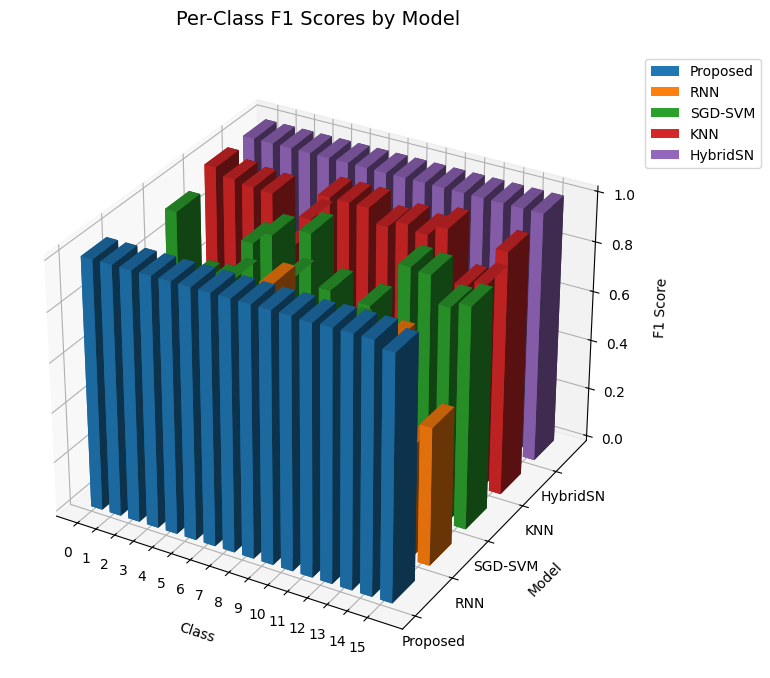

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

# Model info
models = list(results.keys())
num_models = len(models)
num_classes = len(results[models[0]]['F1_per_class'])

# Grid setup
_x = np.arange(num_classes)  # 0 to 15 (classes)
_y = np.arange(num_models)   # 0 to num_models-1
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# Flatten F1 scores
z = []
for model in models:
    z.extend(results[model]['F1_per_class'])
z = np.array(z)

# Assign a distinct color per model
color_list = list(cm.get_cmap('tab10').colors) + list(cm.get_cmap('tab20').colors)
model_colors = [color_list[i % len(color_list)] for i in range(num_models)]
bar_colors = [model_colors[model_idx] for model_idx in y]

# Bar dimensions
bottom = np.zeros_like(z)
width = depth = 0.6

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x, y, bottom, width, depth, z, shade=True, color=bar_colors)

# Labels and ticks
ax.set_xlabel('Class', labelpad=10)
ax.set_ylabel('Model', labelpad=10)
ax.set_zlabel('F1 Score', labelpad=10)
ax.set_xticks(_x)
ax.set_yticks(_y)
ax.set_yticklabels(models)
ax.set_title('Per-Class F1 Scores by Model', fontsize=14, pad=20)

# Custom legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=model_colors[i], label=models[i]) for i in range(num_models)]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
# ✅ Save the figure
filename = f"f1_per_cls.png"
plt.savefig(filename, dpi=300)
print(f"✅ Saved: {filename}")
plt.show()


✅ Saved: Model Performance Metrics.png


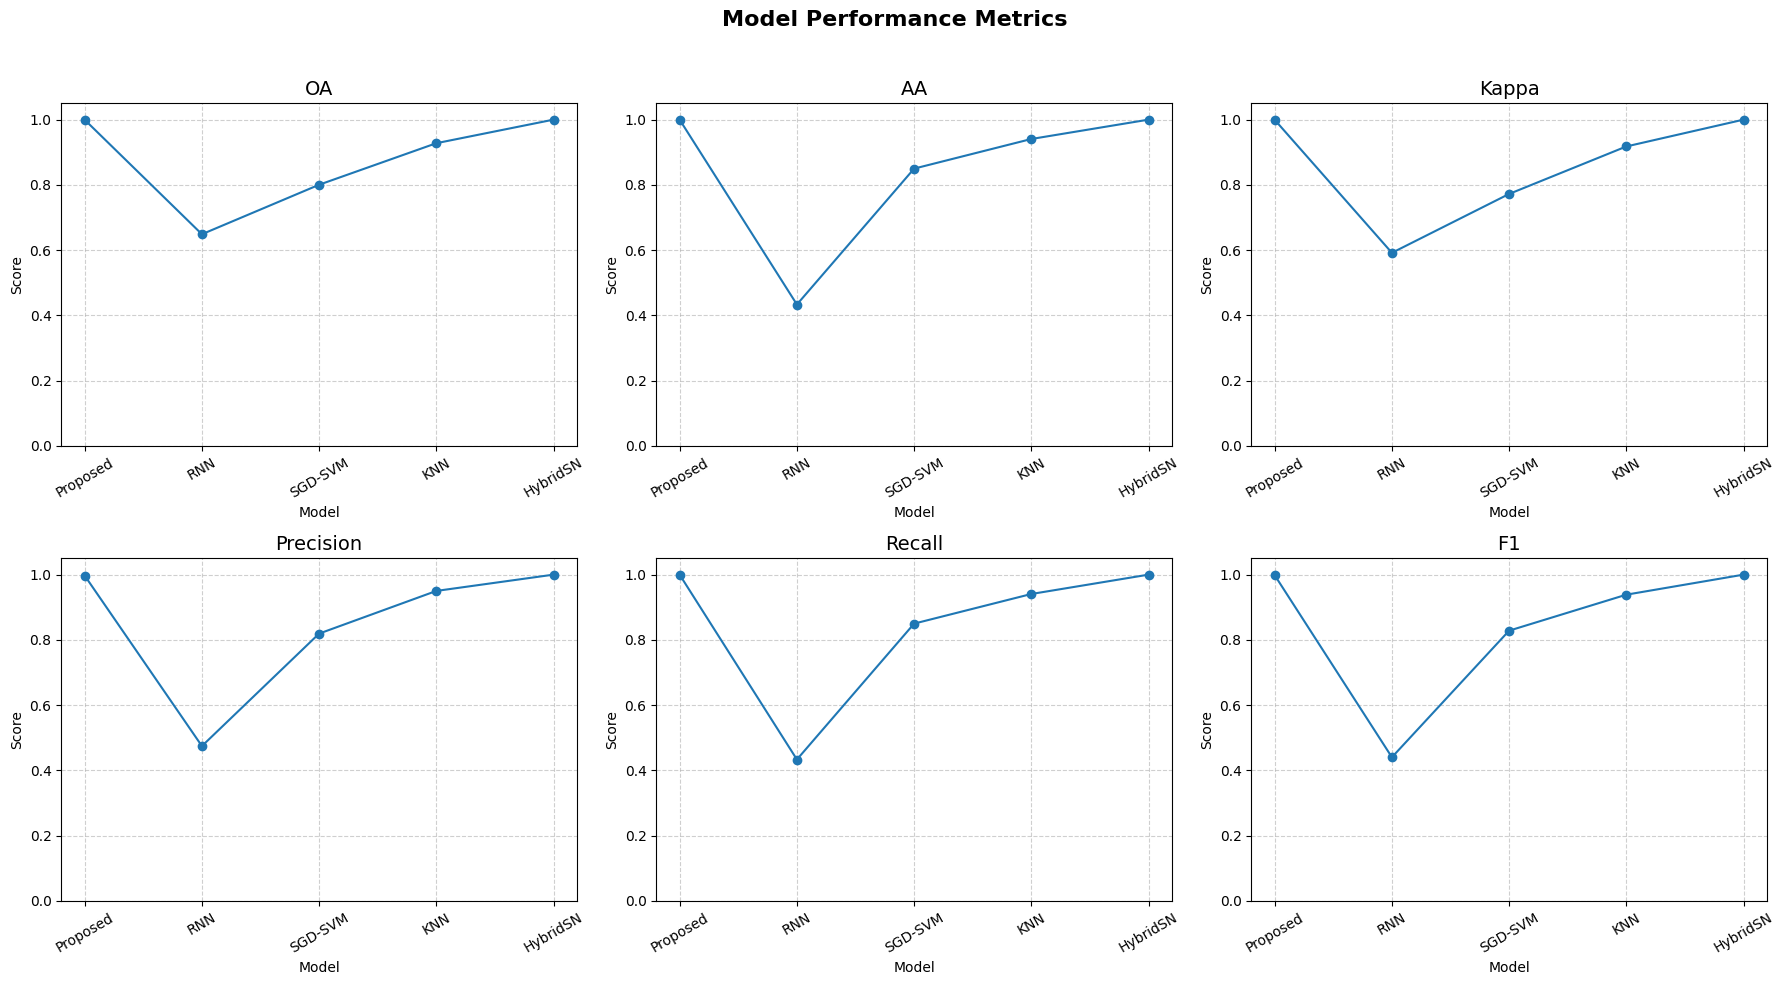

In [53]:
import matplotlib.pyplot as plt

# Models and metrics
models = list(results.keys())
metrics_to_plot = ["OA", "AA", "Kappa", "Precision", "Recall", "F1"]

# Prepare data
metric_data = {metric: [results[model][metric] for model in models] for metric in metrics_to_plot}

# Plot each metric in a separate subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    ax.plot(models, metric_data[metric], marker='o', color='tab:blue')
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=30)

plt.suptitle("Model Performance Metrics", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
# ✅ Save the figure
filename = f"Model Performance Metrics.png"
plt.savefig(filename, dpi=300)
print(f"✅ Saved: {filename}")
plt.show()

✅ Saved: Comparison of Model Performance Metrics.png


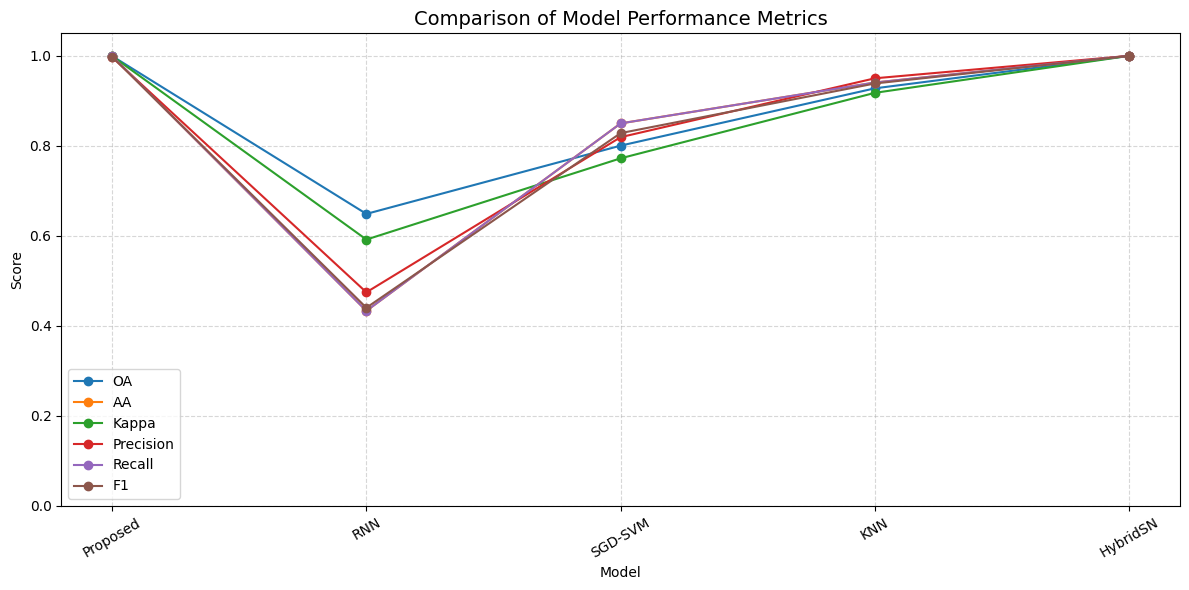

In [54]:
import matplotlib.pyplot as plt

# Models and metrics to plot
models = list(results.keys())
metrics_to_plot = ["OA", "AA", "Kappa", "Precision", "Recall", "F1"]

# Extract metric values
metric_data = {metric: [results[model][metric] for model in models] for metric in metrics_to_plot}

# Plot
plt.figure(figsize=(12, 6))
for metric, values in metric_data.items():
    plt.plot(models, values, marker='o', label=metric)

plt.title('Comparison of Model Performance Metrics', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
# ✅ Save the figure
filename = f"Comparison of Model Performance Metrics.png"
plt.savefig(filename, dpi=300)
print(f"✅ Saved: {filename}")
plt.show()